# Project
## Theofanis Nitsos - p3352325

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

from pysptools.abundance_maps.amaps import NNLS, FCLS
from sklearn import linear_model
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist
from scipy.optimize import minimize

from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.base import BaseEstimator
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# for creating a flattened plot
%matplotlib inline

plt.style.use('default')

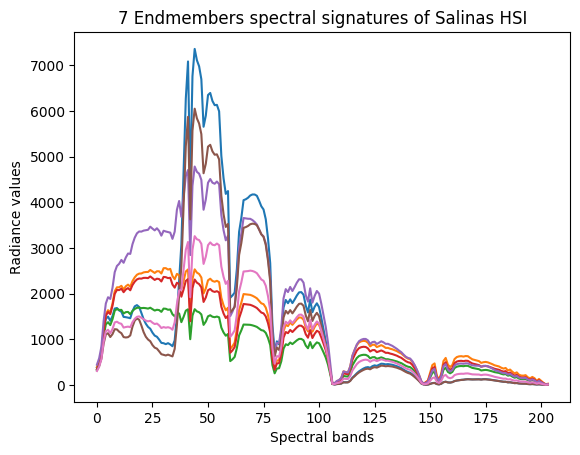

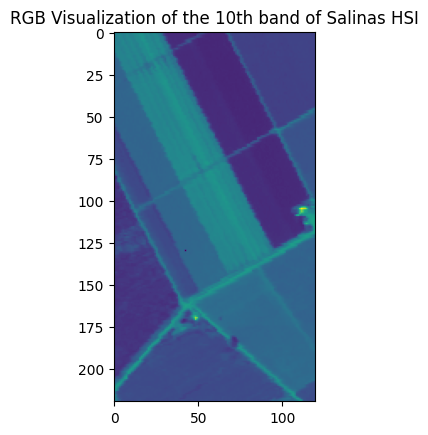

In [2]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

## Part 1

In our case the pure pixels are called endmembers and we have 7 endmembers. As such the spectral unmixing is described as:

$ y = X \theta + \eta$ with   
y : (204x1) each pixel's spectral information  
X : (204x7) where each column represents one of the pure pixel values, essentially the endmembers  
$\theta$ : (7x1) the contribution of each pure pixel to the specific pixel

In [3]:
# Define a function for plotting the maps for each channel
def plot_maps(abundance_maps):
    # Get the number of channels
    num_channels = abundance_maps.shape[2]

    # Create subplots for each channel
    fig, axes = plt.subplots(1, num_channels, figsize=(25, 7))

    # Iterate through channels and plot
    for i in range(num_channels):
        ax = axes[i] if num_channels > 1 else axes  # Handle the case when there's only one channel
        channel_data = abundance_maps[:, :, i]
        ax.imshow(channel_data, cmap='viridis') #'viridis' , 'binary'
        ax.set_title(f'Channel {i + 1}')
        ax.axis('off')
    
    plt.show()

### Least squares

The reconstruction error for the least squares approach is: 35058.88


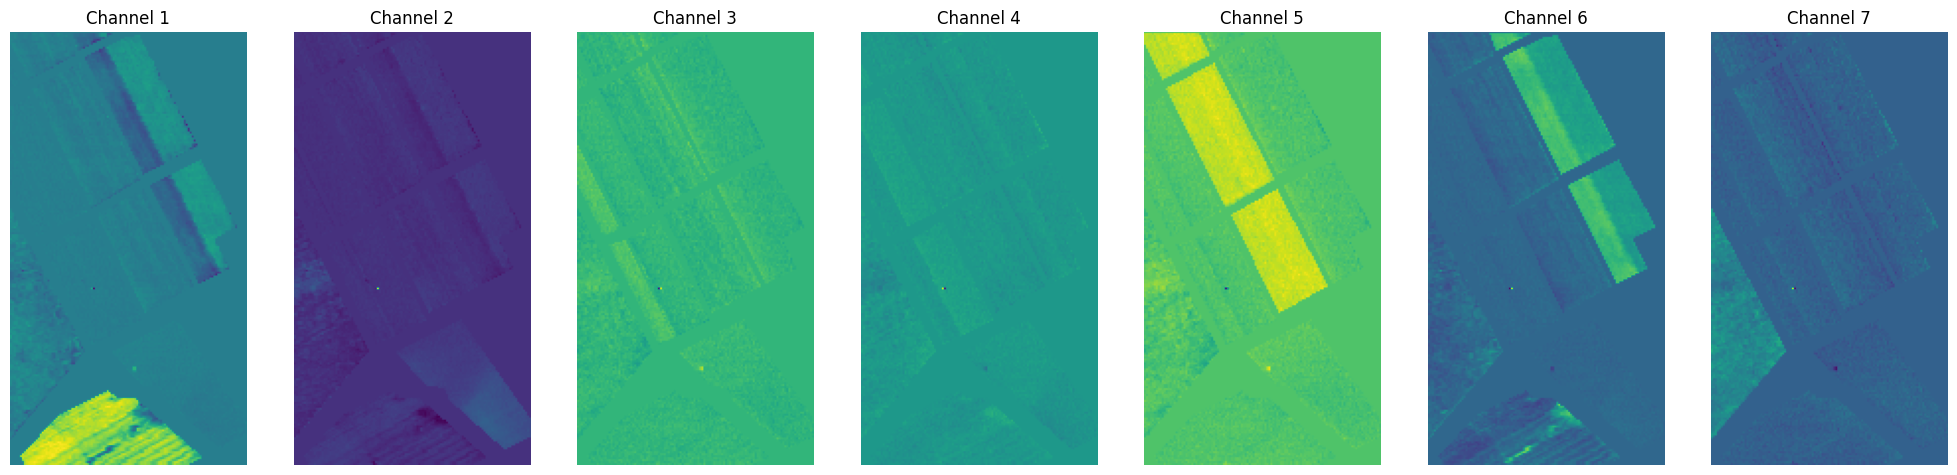

In [4]:
# Create a mask for pixels with no labels
nonzero_mask = labels != 0

# Apply the mask to HSI and labels
HSI_nonzero = HSI[nonzero_mask]
labels_nonzero = labels[nonzero_mask]

# Get the indices of the nonzero pixels
nonzero_indices = np.nonzero(nonzero_mask)

# Use numpy.linalg.lstsq to find theta in the equation y = X * theta
# theta 7x16929
theta, residuals, _, _ = np.linalg.lstsq(endmembers, HSI_nonzero.T, rcond=None)

# Create a new array to store the rearranged HSI
abundance_maps = np.zeros((HSI.shape[0],HSI.shape[1], endmembers.shape[1]))

# Fill the rearranged HSI with the filtered values
abundance_maps[nonzero_indices[0], nonzero_indices[1], :] = theta.T

print(f'The reconstruction error for the least squares approach is: {np.mean(residuals):.2f}')
plot_maps(abundance_maps)

### Least squares imposing the sum-to-one constraint

In [5]:
X = endmembers
y = HSI_nonzero.T

# Define the objective function (sum of squared errors)
def objective(theta, X, y):
    return np.sum((np.dot(X, theta) - y) ** 2)

# Define the constraint function (sum-to-one constraint)
def constraint(theta):
    return np.sum(theta) - 1

# Define the Jacobian of the constraint function
def jac_constraint(theta):
    return np.ones_like(theta)

# Function to compute reconstruction error for each pixel
def compute_reconstruction_error(theta, X, y):
    # Compute reconstruction error for each pixel
    reconstruction_errors = np.sum((np.dot(X, theta) - y) ** 2, axis=0)
    # Take the average over pixels with non-zero class labels
    reconstruction_error = np.mean(reconstruction_errors[y.sum(axis=0) != 0])
    return reconstruction_error

# Initial guess for theta
initial_theta_s1 = np.ones((endmembers.shape[1], HSI_nonzero.shape[0]))
optimal_theta_s1 = np.zeros((endmembers.shape[1], HSI_nonzero.shape[0]))
reconstruction_errors_s1 = []

# Define the optimization problem
problem = {'type': 'eq', 'fun': constraint, 'jac': jac_constraint}

# Solve the optimization problem
for i,row in enumerate(HSI_nonzero):
    result_s1 = minimize(objective, initial_theta_s1[:,i], args=(X, y[:,i]), constraints=problem, method='SLSQP')
    
    # Extract the solution
    optimal_theta_s1[:,i] = result_s1.x
    
    # Extract the reconstruction error
    reconstruction_error_s1 = compute_reconstruction_error(optimal_theta_s1[:,i], X, y[:, i])
    reconstruction_errors_s1.append(reconstruction_error_s1)

In [6]:
# Check that the Sum of theta are 1
matrix = np.sum(optimal_theta_s1, axis=0)
mask = (matrix > 0.999) & (matrix < 1.0001)
print(f'The elements of theta that sum above 0.999 and below 1.0001 are: {np.sum(mask):} out of : {matrix.shape[0]:}')

The elements of theta that sum above 0.999 and below 1.0001 are: 16929 out of : 16929


The reconstruction error for the least squares approach with sum to one constraint is: 43082.58


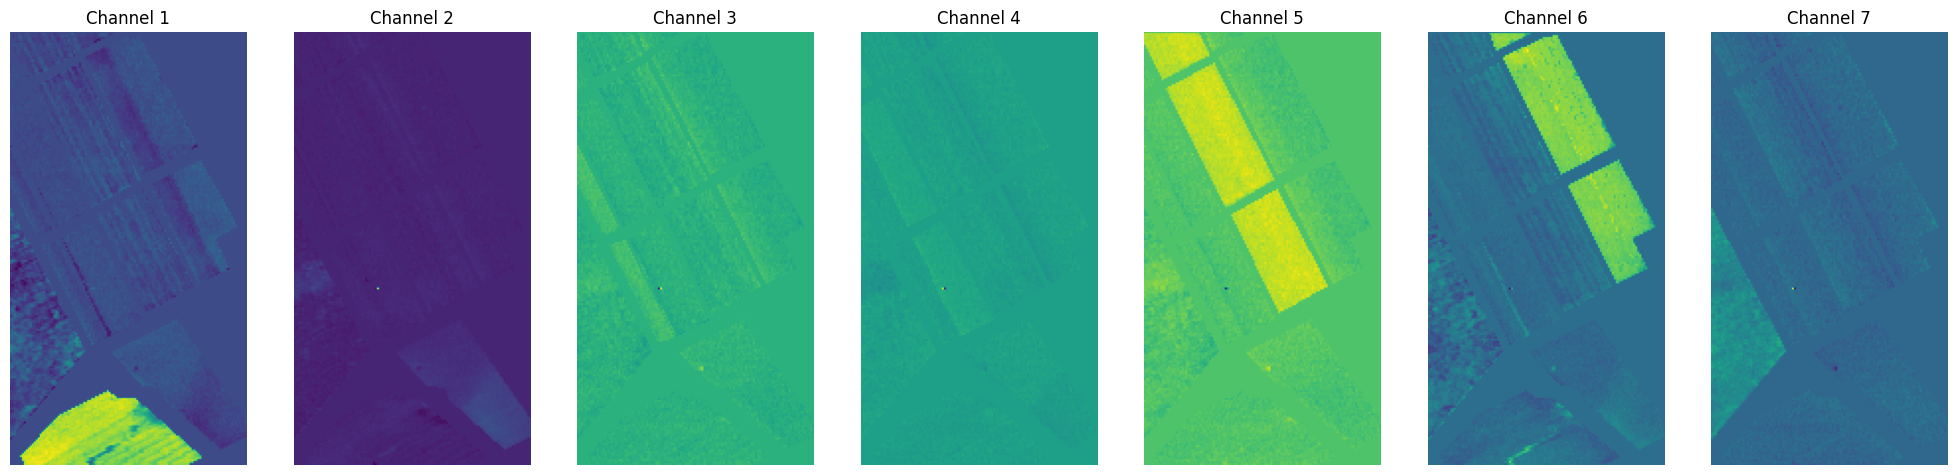

In [7]:
# Create a new array to store the rearranged HSI
abundance_maps_s1 = np.zeros((HSI.shape[0],HSI.shape[1], endmembers.shape[1]))

# Fill the rearranged HSI with the filtered values
abundance_maps_s1[nonzero_indices[0], nonzero_indices[1], :] = optimal_theta_s1.T

print(f'The reconstruction error for the least squares approach with sum to one constraint is: {np.mean(reconstruction_errors_s1):.2f}')
plot_maps(abundance_maps_s1)

### Least squares imposing the non-negativity constraint

In [8]:
import numpy as np
from scipy.optimize import nnls

theta_nn = np.zeros((endmembers.shape[1], HSI_nonzero.shape[0]))
residuals_nn = np.zeros(( HSI_nonzero.shape[0]))

for i,row in enumerate(HSI_nonzero):
    theta_nn[:,i], residuals_nn[i] = nnls(endmembers, HSI_nonzero[i,:])

In [9]:
# Check that theta does not include negative elements
mask = (theta_nn < 0)
print(f'The negative elements of theta are: {np.sum(mask)} ')

The negative elements of theta are: 0 


The reconstruction error for theta greater than 0 is: 320.55


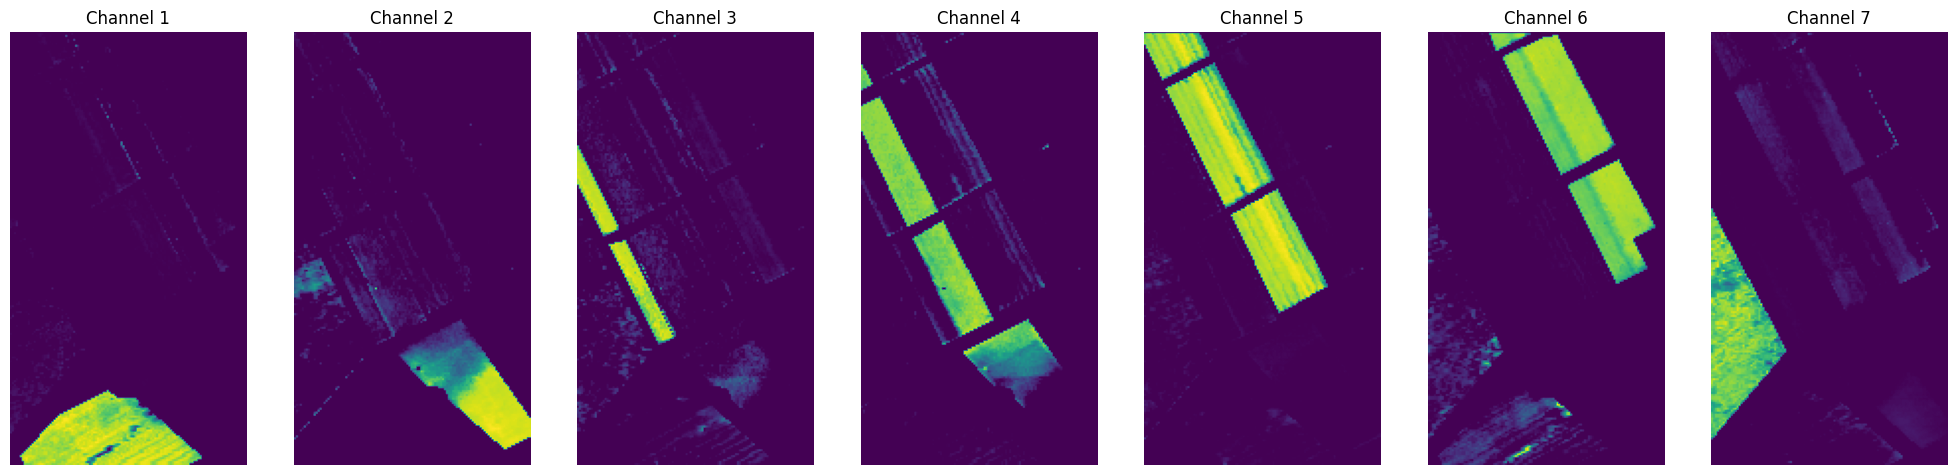

In [10]:
# Create a new array to store the rearranged HSI
abundance_maps_nn = np.zeros((HSI.shape[0],HSI.shape[1], endmembers.shape[1]))

# Fill the rearranged HSI with the filtered values
abundance_maps_nn[nonzero_indices[0], nonzero_indices[1], :] = theta_nn.T

print(f'The reconstruction error for theta greater than 0 is: {np.mean(residuals_nn):.2f}')
plot_maps(abundance_maps_nn)

In [11]:
abundance_maps_nn.shape

(220, 120, 7)

### Least squares imposing both the non-negativity and the sum-to-one constraint on the entries of θ

#### First approach

In the first approach we will avoid using an optimisation algorithm to ensure that both conditions of non-negativity and sum-to-one are applied in full. 


In [12]:
import numpy as np
from scipy.optimize import nnls

theta_init = np.zeros((endmembers.shape[1], HSI_nonzero.shape[0]))
theta_nn_s1 = np.zeros((endmembers.shape[1], HSI_nonzero.shape[0]))
reconstruction_errors_nn_s1 = []

for i,row in enumerate(HSI_nonzero):
    theta_init[:,i], _ = nnls(endmembers, HSI_nonzero[i,:])
    theta_nn_s1[:,i] = theta_init[:,i] / theta_init[:,i].sum()
    reconstruction_error_nn_s1 = compute_reconstruction_error(theta_nn_s1[:,i], endmembers, HSI_nonzero[i, :])
    reconstruction_errors_nn_s1.append(reconstruction_error_nn_s1)
    

In [13]:
# Check that theta does not include negative elements
mask = (theta_nn_s1 < 0)
print(f'The negative elements of theta are: {np.sum(mask)} ')

The negative elements of theta are: 0 


In [14]:
# Check that the Sum of theta are 1
matrix = np.sum(theta_nn_s1, axis=0)
mask = (matrix > 0.999) & (matrix < 1.001)
print(f'The elements of theta that sum above 0.999 and below 1.0001 are: {np.sum(mask):} ')

The elements of theta that sum above 0.999 and below 1.0001 are: 16929 


The reconstruction error for theta greater than 0 and theta_i sum to one is: 1520302.94


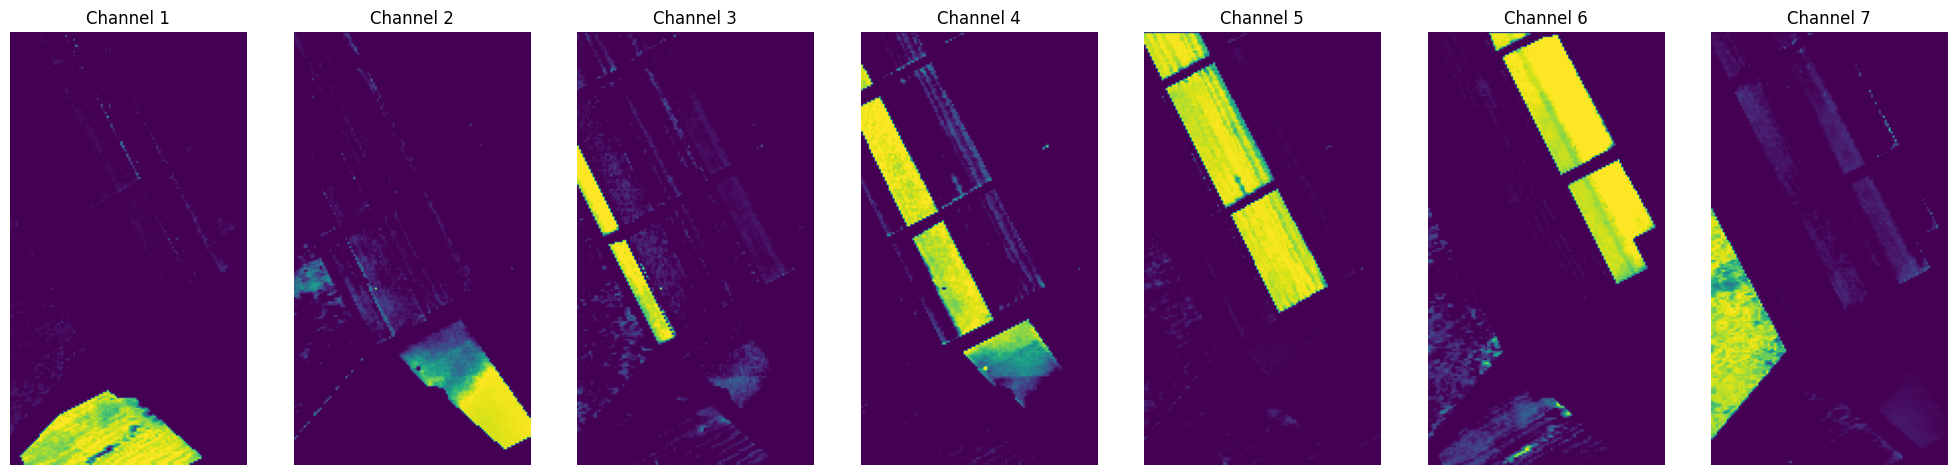

In [15]:
# Create a new array to store the rearranged HSI
abundance_maps_nn_s1 = np.zeros((HSI.shape[0],HSI.shape[1], endmembers.shape[1]))

# Fill the rearranged HSI with the filtered values
abundance_maps_nn_s1[nonzero_indices[0], nonzero_indices[1], :] = theta_nn_s1.T

print(f'The reconstruction error for theta greater than 0 and theta_i sum to one is: {np.mean(reconstruction_errors_nn_s1):.2f}')
plot_maps(abundance_maps_nn_s1)

We notice that indeed there are no negative elements and the $\sum \theta = 1$ but the reconstruction error is drastically increased. For this reason below we will use an optimise function attempting to reduce the reconstruction error at the expense of our constratints. 

#### 2nd approach

In the second approach the constraints for sum-to-one and non-negativity are violated (because of the optimisation) but the reconstruction error is significantly reduced. It is worth noting that the maps are very similar. As such the errors either are due to small differences in the pixel (which are not easily distinguished in the maps) or because of a calculation error.

In [16]:
theta_FCLS = np.zeros(shape=(220,120,7))
error = np.zeros(shape=(220,120))
reconstruct = np.zeros(shape=(220,120,204))

# iterate throughput the labels table and if the label in non zero calculate theta for y [204x1] and X [204x7]
for i, row in enumerate(labels):
    for j, l in enumerate(row):
        if l != 0:
            y = HSI[i,j,:].reshape(-1,1)
            theta_FCLS[i,j] = FCLS(y.astype(np.double).T, X.astype(np.double).T)
            reconstruct[i,j,:] = np.dot(X, theta_FCLS[i,j].reshape(7,1)).flatten()
            error[i,j] = np.linalg.norm(HSI[i,j,:] - reconstruct[i,j,:])**2
            


In [17]:
# Check that theta does not include negative elements
mask = (theta_FCLS < 0)
print(f'The negative elements of theta are: {np.sum(mask)} ')

The negative elements of theta are: 25639 


The reconstruction error for theta greater than 0 and theta_i sum to one is: 738727.05


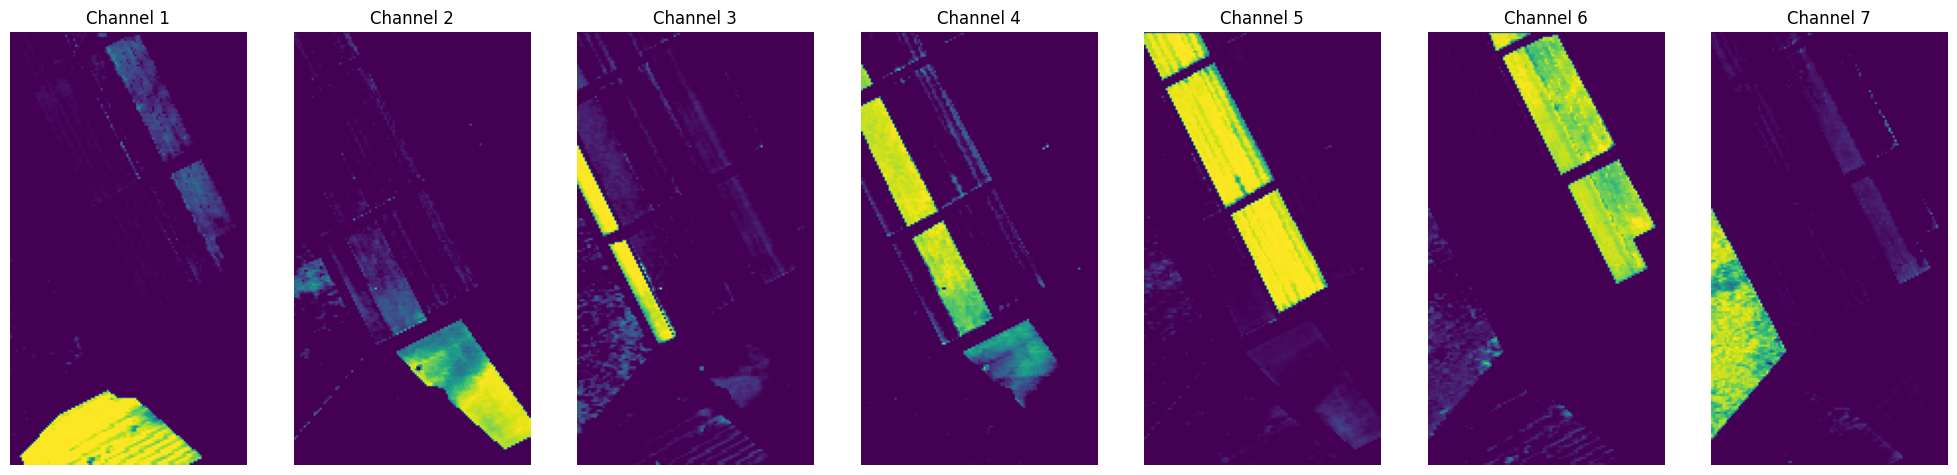

In [18]:
print(f'The reconstruction error for theta greater than 0 and theta_i sum to one is: {np.mean(error[nonzero_mask]):.2f}')
plot_maps(theta_FCLS)

Below i try to figure out why although the maps for the 2 different approaches for the sum-to-one and non-negativity constraints are very similar the error seems to be very different. Substracting the $\theta$ results in a table which 175921 out of 184800 elements lie between $-0.1 < x < 0.1$ meaning there are slight differences in most of the elements of this table. 

In [19]:
diff = (abundance_maps_nn_s1 - theta_FCLS)

mask = (diff > -0.1) & (diff < 0.1)

# Count the number of True values in the mask
count = np.sum(mask)

print("Number of elements between -0.1 and 0.1:", count, "out of", diff.shape[0]*diff.shape[1]*diff.shape[2])

Number of elements between -0.1 and 0.1: 175921 out of 184800


### LASSO

In [20]:
from sklearn.linear_model import Lasso

# Define the LASSO model
lasso_model = Lasso(alpha=10)  # You can adjust alpha as needed

theta_lasso = np.zeros((endmembers.shape[1], HSI_nonzero.shape[0]))
residuals_lasso = np.zeros(HSI_nonzero.shape[0])

# Fit the LASSO model for each pixel
for i in range(HSI_nonzero.shape[0]):
    lasso_model.fit(endmembers, HSI_nonzero[i, :]) 
    theta_lasso[:, i] = lasso_model.coef_
    # Calculate residuals
    residuals_lasso[i] = np.sum((HSI_nonzero[i, :] - np.dot(endmembers, lasso_model.coef_)) ** 2)


The reconstruction error for LASSO: 81568.70


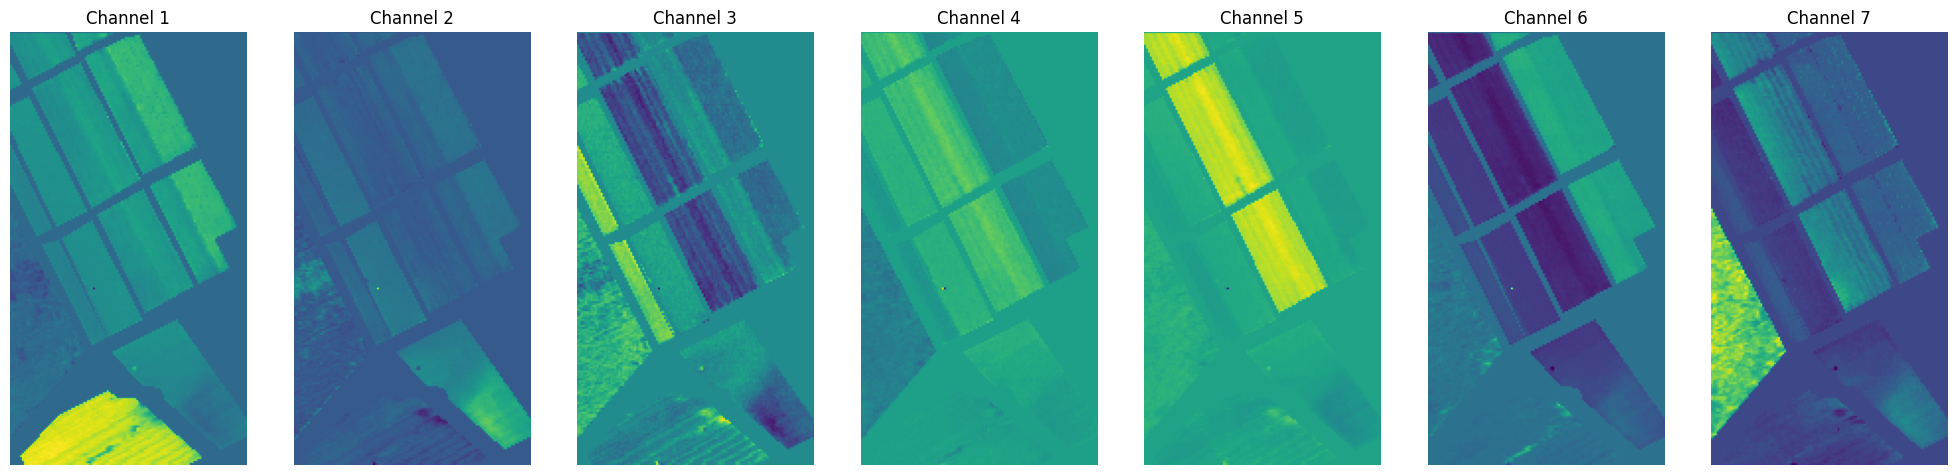

In [21]:
print(f'The reconstruction error for LASSO: {np.mean(residuals_lasso):.2f}')
# Create a new array to store the rearranged HSI
abundance_maps_lasso = np.zeros((HSI.shape[0],HSI.shape[1], endmembers.shape[1]))

# Fill the rearranged HSI with the filtered values
abundance_maps_lasso[nonzero_indices[0], nonzero_indices[1], :] = theta_lasso.T

plot_maps(abundance_maps_lasso)

## Compare the results obtained from the above five methods

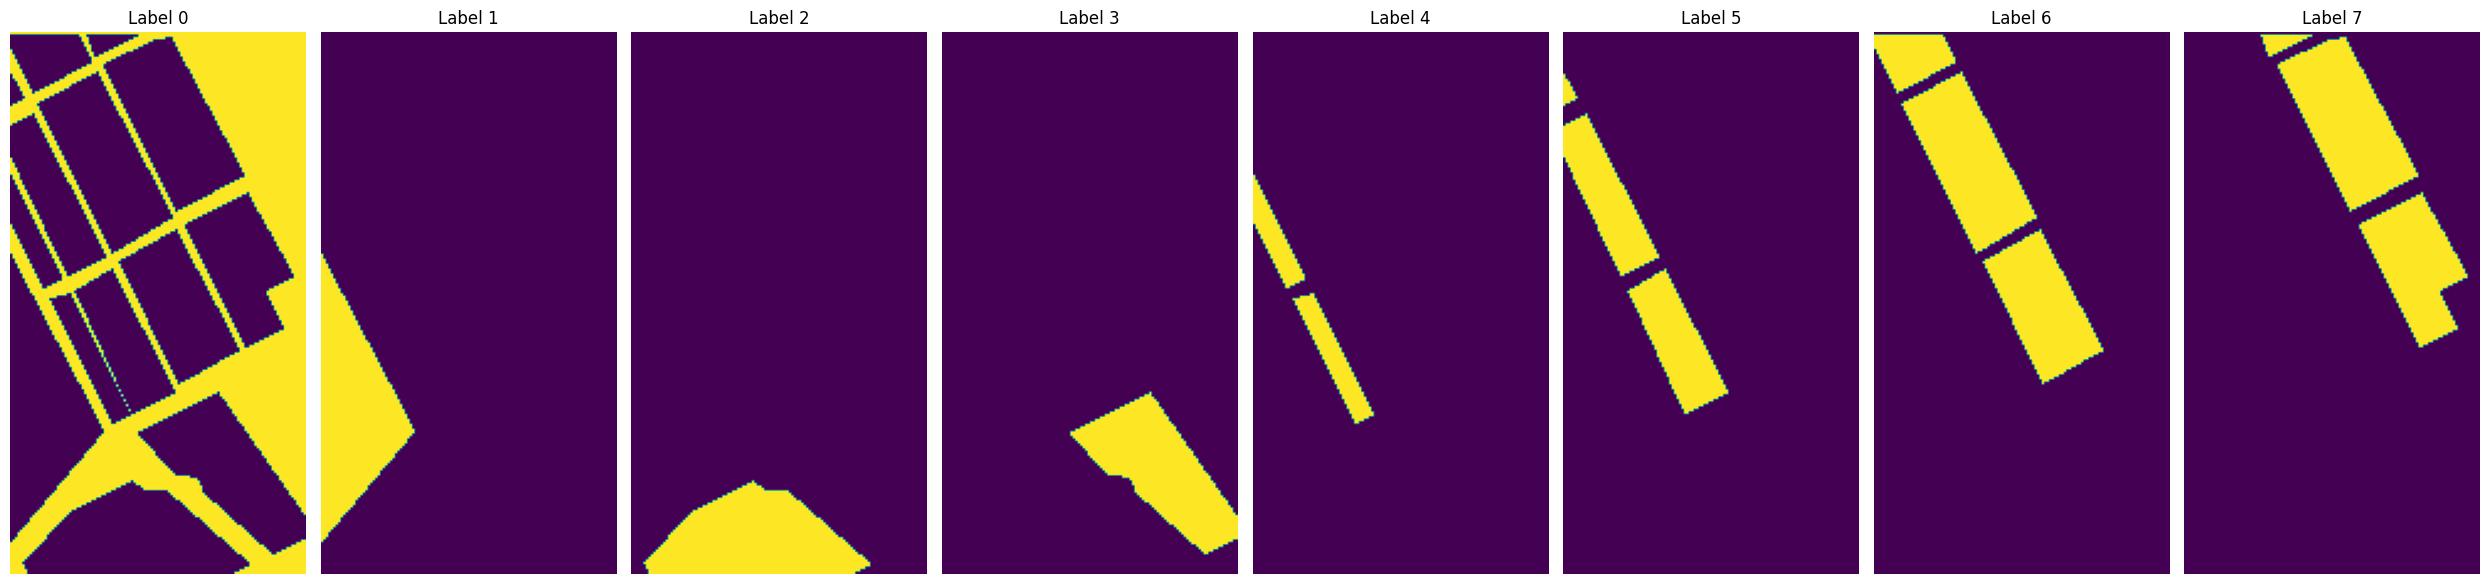

In [22]:
# Define the number of unique labels (0 to 7)
num_labels = 8

# Create subplots for each unique label
fig, axes = plt.subplots(1, num_labels, figsize=(25, 7))  # Adjust figsize as needed

# Loop over each unique label
for i in range(num_labels):
    # Create a binary mask where pixels with the current label are set to 1, others to 0
    mask = labels == i
    
    # Plot the image for the current label
    axes[i].imshow(mask, cmap='viridis')  # You can choose a different colormap if needed
    axes[i].set_title(f"Label {i}")      # Set the title for each subplot
    axes[i].axis('off')                  # Turn off axes
    
plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

#### Method comparison
We will compare the results on the basis of the maps produced and on the reconstruction error.

Based on the maps the best results, which achieve class separation, are achieved using the LS with non-negativity contraint along with the LS with  non-negativity contraint and sum-to-one. Both methods are able to distinguish the classes although their reconstruction errors are significantly different. LS and LS sum-to-one methods can distinguish some materials but not all of them while LASSO is underperforming in separating the different materials.

Upon closer look at the maps we can see that there is a difficutly in separating Fallow 1, Fallow 2 and Fallow 3 which makes sense since it is the same material.

Moving on to the reconstruction errors, we got the following results:

|Method|Reconstruction Error|
|--|--:|
|LS non-negativity|320.55|
|Least squares|35058.88|
|LS sum-to-one|43082.58|
|LASSO |81568.7|
|LS non-negativity and sum-to-one|738727.05|

With the exception of the non-negativity constraint it appears that the more contrains, the higher the reconstruction error.

The non-negativity constraint seems to make sense from a physical point of view but so does the sum-to-one. Adding more constraints overdefines the problem leading to poor separation between the materials. That could be attributed to the noise that we cannot exclude from our calculations and that more complicated models (with more constraints) are more severely affected. Either that either the error is incorrectly calculated.

## Part 2 classification

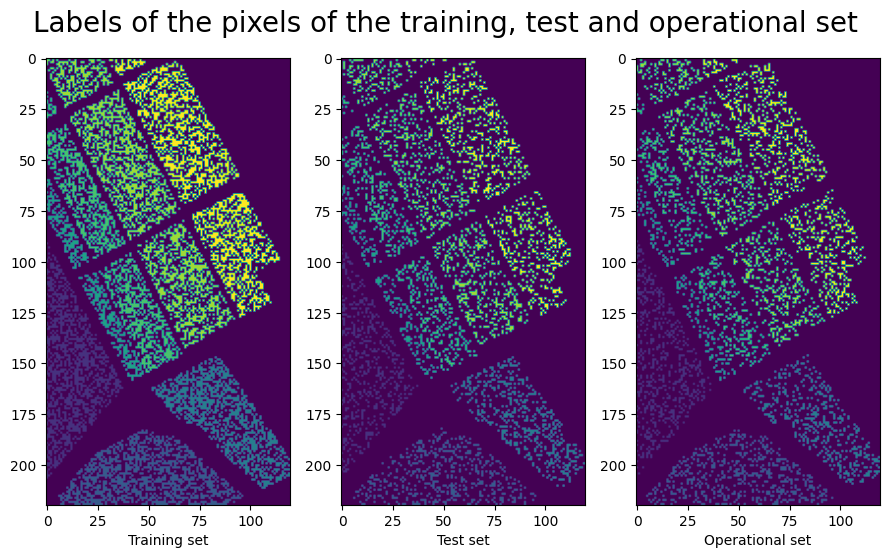

In [23]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T


# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

axes[0].imshow(Training_Set)
axes[1].imshow(Test_Set)
axes[2].imshow(Operational_Set)

axes[0].set_xlabel(f'Training set')
axes[1].set_xlabel(f'Test set')
axes[2].set_xlabel(f'Operational set')

# Title
fig.suptitle('Labels of the pixels of the training, test and operational set', x=0.3, y=0.75, fontsize=20)
fig.tight_layout(rect =(0, 0, 0.6, 1))

In [24]:
def f_datasets(input, HSI):

    X = []
    y = []
    input_filtered = input[input != 0]
    HSI_filtered = HSI[input !=0]
    for i, row in enumerate(input_filtered):
        hyperspectral_row = HSI_filtered[i,:]
        X.append(hyperspectral_row)
        y_append =  input_filtered[i]
        y.append(y_append)
        
    return np.array(X), np.array(y)

# Extract features (X) and labels (y)
X_test, y_test = f_datasets(Test_Set, HSI)
X_train, y_train = f_datasets(Training_Set, HSI)

X_opt, y_opt = f_datasets(Operational_Set, HSI)


In [25]:
def plot_confusion_matrix(clf, X, y):
    print(f'Accuracy: {accuracy_score(clf.predict(X), y_test)*100:.2f}%\n')

    print("Confusion matrix:")
    cf_matrix = confusion_matrix(y, clf.predict(X), normalize='pred')
    
    # get unique labels 
    labels_y = np.unique(y, axis=0)

    # max value of cmatrix 
    max_cm = cf_matrix.max()
    ax = sns.heatmap(cf_matrix, annot=True,  fmt='.2%', xticklabels=labels_y, yticklabels=labels_y,
                cbar=False, vmin=0, vmax=max_cm)
    cbar = ax.figure.colorbar(ax.collections[0])
    cbar.set_ticks([0, max_cm])
    _ = cbar.set_ticklabels(["0%", f"{max_cm*100:.2f}%"])

### a. Naïve Bayes classifier

In [26]:
# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Perform 10-fold cross-validation
cv_scores = cross_val_score(nb_classifier, X_train, y_train, cv=10, scoring='accuracy')

# Calculate the mean and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_accuracy = cv_scores.std()

print(f"Mean Cross-Validation Error for Naive Bayes: {(1-mean_accuracy)*100:.2f}%")
print(f"Standard Deviation of Cross-Validation Accuracy for Naive Bayes: {std_accuracy*100:.2f}%")

# Train the classifier on the entire training set
nb_classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = nb_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Set Accuracy for Naive Bayes: {test_accuracy*100:.2f}%")

Mean Cross-Validation Error for Naive Bayes: 2.62%
Standard Deviation of Cross-Validation Accuracy for Naive Bayes: 1.60%
Test Set Accuracy for Naive Bayes: 98.13%


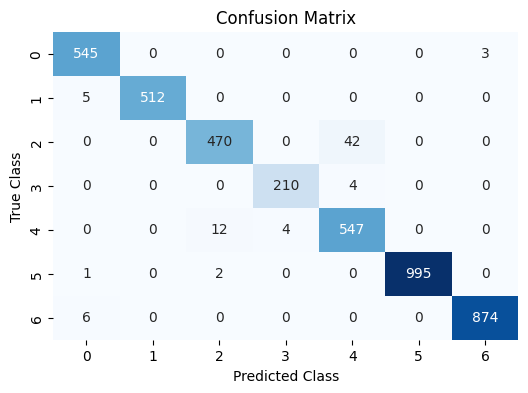

Misclassified Classes: [0 1 2 3 4 5 6]
Success Rate: 98.13%


In [27]:
# Evaluate the classifier on the test set
y_pred = nb_classifier.predict(X_test)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Identify classes that are not well separated
misclassified_classes = np.where(conf_matrix.sum(axis=1) - np.diag(conf_matrix) > 0)[0]
print("Misclassified Classes:", misclassified_classes)

# Compute success rate of the classifier
success_rate = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Success Rate: {success_rate:.2%}")

### b. Minimum Euclidean distance classifier

Mean Validation Error (Min Euclidean dist): 0.37%
Standard Deviation of Validation Error (Min Euclidean dist): 0.26%
Success Rate (Min Euclidean dist): 99.74%


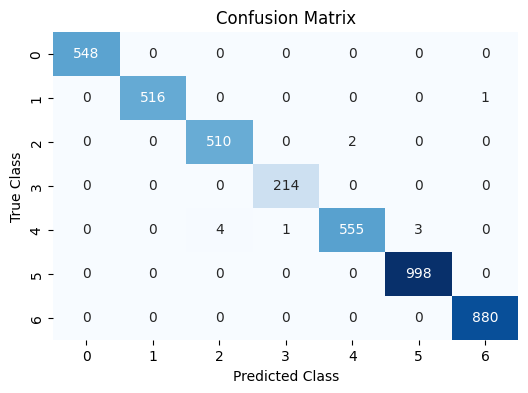

Misclassified Classes: [1 2 4]


In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Define the minimum Euclidean distance classifier
class MinEuclideanDistanceClassifier:
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X):
        y_pred = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            min_index = np.argmin(distances)
            y_pred.append(self.y_train[min_index])
        return np.array(y_pred)

# Implement 10-fold cross-validation
def cross_validation(model, X, y, k=10):
    n = len(y)
    indices = np.arange(n)
    np.random.shuffle(indices)
    fold_size = n // k
    errors = []

    for i in range(k):
        val_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate((indices[:i * fold_size], indices[(i + 1) * fold_size:]))

        X_train_fold = X[train_indices]
        y_train_fold = y[train_indices]
        X_val_fold = X[val_indices]
        y_val_fold = y[val_indices]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        error = np.mean(y_pred != y_val_fold)
        errors.append(error)

    return np.mean(errors), np.std(errors)


classifier = MinEuclideanDistanceClassifier()

# 10-fold cross-validation
validation_error_mean, validation_error_std = cross_validation(classifier, X_train, y_train)

# Training on the whole training set
classifier.fit(X_train, y_train)

# Evaluation on the test set
y_pred_test = classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

success_rate = np.diag(conf_matrix).sum() / conf_matrix.sum()

print(f"Mean Validation Error (Min Euclidean dist): {validation_error_mean*100:.2f}%")
print(f"Standard Deviation of Validation Error (Min Euclidean dist): {validation_error_std*100:.2f}%")
print(f"Success Rate (Min Euclidean dist): {success_rate:.2%}")

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Identify classes that are not well separated
misclassified_classes = np.where(conf_matrix.sum(axis=1) - np.diag(conf_matrix) > 0)[0]
print("Misclassified Classes:", misclassified_classes)


### c. k-nearest neighbor classifier 

Mean Validation Error (KNN): 0.89%
Standard Deviation of Validation Error (KNN): 1.30%
Success Rate (KNN): 99.72%


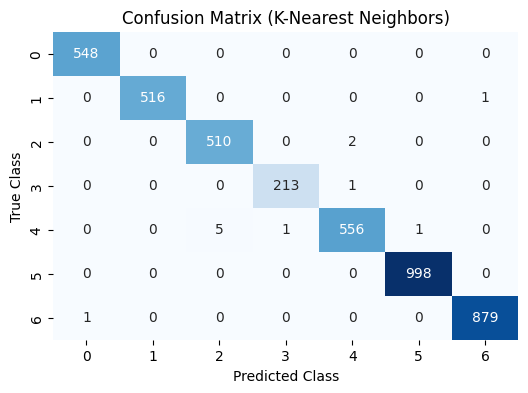

Misclassified Classes (K-Nearest Neighbors): [1 2 3 4 6]


In [29]:
# Create and train the KNeighborsClassifier (replace 'n_neighbors' with your desired value)
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

kn_error = 1 - cross_val_score(knn_classifier, X_train, y_train, cv=10)

# Evaluate the classifier on the test set
y_pred_knn = knn_classifier.predict(X_test)

# Calculate and print the confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
success_rate_knn = accuracy_score(y_test, y_pred_knn)

print(f"Mean Validation Error (KNN): {kn_error.mean()*100:.2f}%")
print(f"Standard Deviation of Validation Error (KNN): {kn_error.std()*100:.2f}%")
print(f"Success Rate (KNN): {success_rate_knn:.2%}")

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix (K-Nearest Neighbors)')
plt.show()

# Identify classes that are not well separated
misclassified_classes_knn = np.where(conf_matrix_knn.sum(axis=1) - np.diag(conf_matrix_knn) > 0)[0]
print("Misclassified Classes (K-Nearest Neighbors):", misclassified_classes_knn)



In [30]:
y_pred_knn.shape

nonzero_mask_op = Training_Set != 0

y_test_original_shape = np.zeros(Training_Set.shape)

y_test_original_shape[nonzero_mask_op].shape

(8465,)

In [31]:
print(y_pred_knn.shape, y_test.shape, X_test.shape, Training_Set.shape)

(4232,) (4232,) (4232, 204) (220, 120)


### d. Bayesian classifier

Mean Validation Error (Bayesian Classifier): 3.43%
Standard Deviation of Validation Error (Bayesian Classifier): 0.59%
Success Rate (Bayesian Classifier): 97.78%


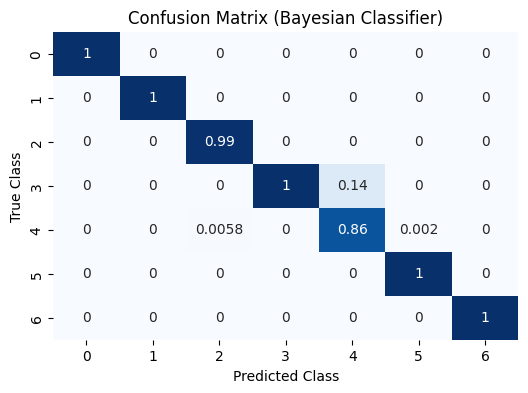

Misclassified Classes (Bayesian Classifier): [3 4]


In [32]:
qd = QuadraticDiscriminantAnalysis()
qd_error = 1 - cross_val_score(qd, X_train, y_train, cv=10)

qd.fit(X_train, y_train)

y_pred_cv = qd.predict(X_test)
conf_matrix_cv = confusion_matrix(y_test, qd.predict(X_test), normalize='pred')

print(f"Mean Validation Error (Bayesian Classifier): {qd_error.mean()*100:.2f}%")
print(f"Standard Deviation of Validation Error (Bayesian Classifier): {qd_error.std()*100:.2f}%")
print(f"Success Rate (Bayesian Classifier): {accuracy_score(qd.predict(X_test), y_test)*100:.2f}%")

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_cv, annot=True,  cmap='Blues', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix (Bayesian Classifier)')
plt.show()

# Identify classes that are not well separated
misclassified_classes_cv = np.where(conf_matrix_cv.sum(axis=1) - np.diag(conf_matrix_cv) > 0)[0]
print("Misclassified Classes (Bayesian Classifier):", misclassified_classes_cv)



## 2.B Compare the results of the classifier

The results are summarized below

|classifier|Accuracy|
|---|---|
|Minimum Euclidean distance|99.74%|
|k-nearest Neighbor| 99.72%|
|Naive Bayes|98.13%|
|Bayesian|97.78%|

The best classifier appears to be the Minimum Euclidean distance and the k-nearest Neighbor method, followed by the Naive Bayes. But in general all classifiers produce very good accuracy. 

Looking at the confusion matrices we can see that most miss-classification occur between classes 4 and 5, with some error happening between 3 and 5. This makes sense because its the same material.

## Part 3


For this part of the project we will apply some of the methods obtained from the regressions and classification tasks (Part 1 & 2) to the operational dataset. 

Spectral unmixing can provide valuable information about the composition of each pixel in the image, revealing the presence and relative abundance of different materials. This information can then be used as features for classification. 

By combining spectral unmixing with classification, we can leverage the complementary strengths of both approaches to better understand and characterize the spectral content of the image, leading to more accurate and informative classification results.

In this part this is exactly what we will do. In detail:  
- We will train a kNN classifier on the full spectra (204) training dataset and validate it on the operational dataset.
- We first use spectral unmixing on the training dataset using the full spectra (204) to end up with 7 categories (the predefined ones) and then train the kNN algorithm on this dataset validating its performance on the operational dataset.

In the first place we will the Operational_Set dataset as a map to better visualise the give data.


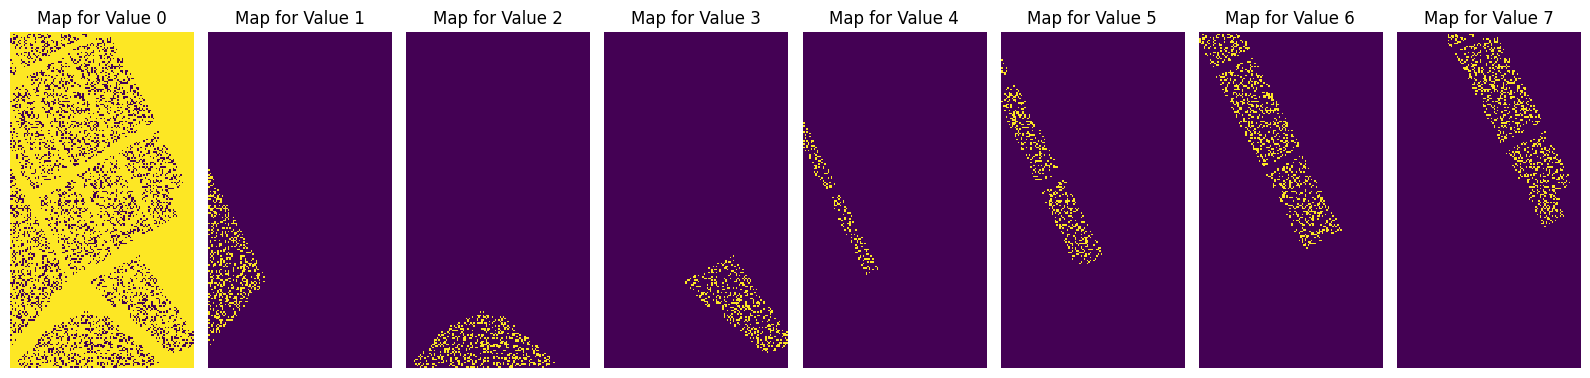

In [33]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(1, 8, figsize=(16, 8))

# Iterate through each value to plot the corresponding map
for value, ax in enumerate(axes.flatten()):
    # Create a mask where pixels with the specific value are set to 1
    mask = np.where(Operational_Set == value, 1, 0)

    # Plot the map
    ax.imshow(mask, cmap='viridis', interpolation='nearest')
    ax.set_title(f"Map for Value {value}")
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In the second part we will apply classification kNN algorithm to the operational dataset using all 204 spectra and print the maps again. The algorithm is trained with the training dataset and is applied on the operational dataset

In [34]:
# Create a mask for pixels with no labels
nonzero_mask_op = Operational_Set != 0

y_pred_knn_opt = knn_classifier.predict(X_opt)

y_pred_opt = np.zeros(shape=(220,120))

y_pred_opt[nonzero_mask_op] = y_pred_knn_opt


# Get the indices of the nonzero pixels
#nonzero_indices = np.nonzero(nonzero_mask)

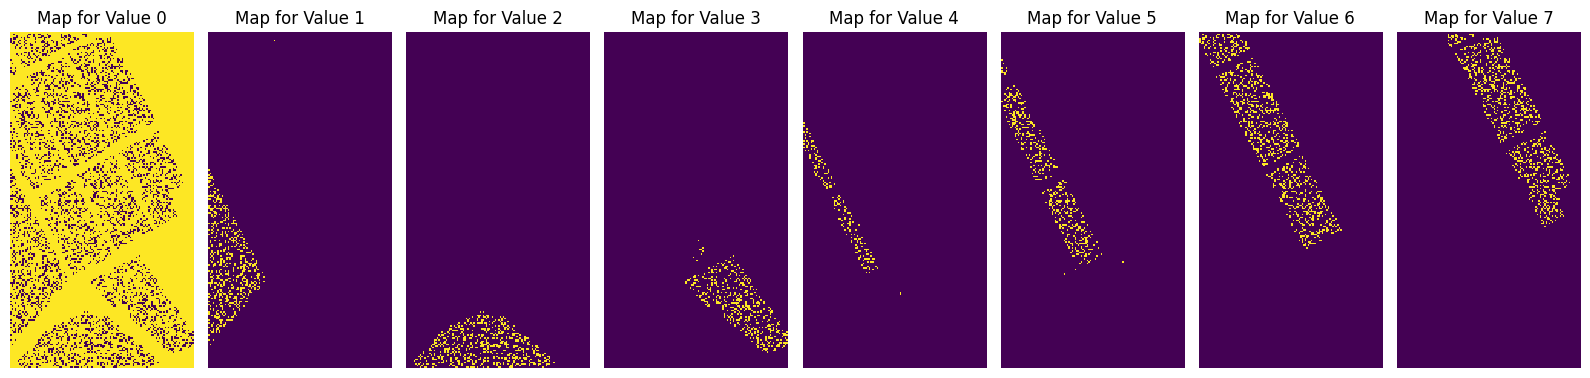

In [35]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(1, 8, figsize=(16, 8))

# Iterate through each value to plot the corresponding map
for value, ax in enumerate(axes.flatten()):
    # Create a mask where pixels with the specific value are set to 1
    mask = np.where(y_pred_opt == value, 1, 0)

    # Plot the map
    ax.imshow(mask, cmap='viridis', interpolation='nearest')
    ax.set_title(f"Map for Value {value}")
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [36]:
# Calculate accuracy
accuracy = accuracy_score(y_opt, y_pred_knn_opt)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.9959829867674859


The results of the classification are really similar to the original operational dataset  

Now we will apply spectral unmixing using Least squares non-negativity constraint and plot the maps again

In [37]:
nonzero_mask_op = Operational_Set != 0

# Apply the mask to HSI and labels
HSI_nonzero_op = HSI[nonzero_mask_op]
labels_nonzero_op = labels[nonzero_mask_op]

# Get the indices of the nonzero pixels
nonzero_indices_op = np.nonzero(nonzero_mask_op)

theta_nn_op = np.zeros((endmembers.shape[1], HSI_nonzero_op.shape[0]))
residuals_nn_op = np.zeros(( HSI_nonzero_op.shape[0]))

for i,row in enumerate(HSI_nonzero_op):
    theta_nn_op[:,i], residuals_nn_op[i] = nnls(endmembers, HSI_nonzero_op[i,:])

The reconstruction error for theta greater than 0 is: 320.41


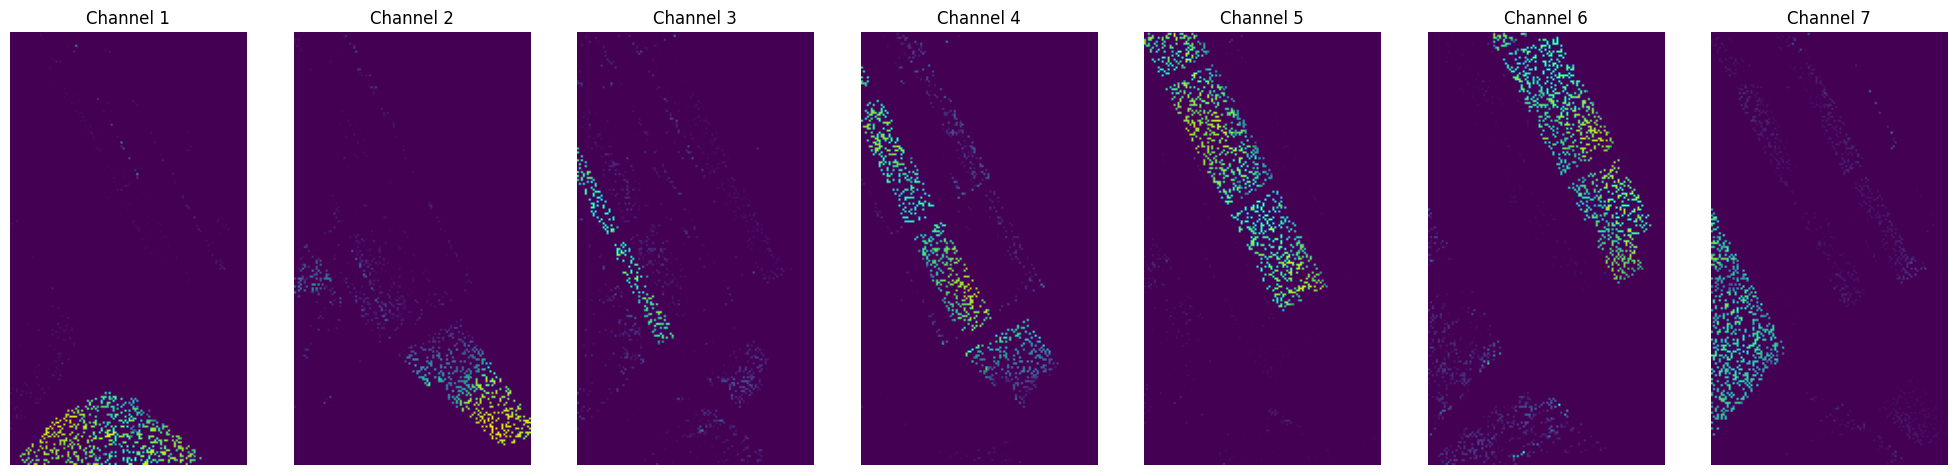

In [38]:
# Create a new array to store the rearranged HSI
abundance_maps_nn_op = np.zeros((HSI.shape[0],HSI.shape[1], endmembers.shape[1]))

# Fill the rearranged HSI with the filtered values
abundance_maps_nn_op[nonzero_indices_op[0], nonzero_indices_op[1], :] = theta_nn_op.T

print(f'The reconstruction error for theta greater than 0 is: {np.mean(residuals_nn_op):.2f}')
plot_maps(abundance_maps_nn_op)

Again the results are very similar (judging from the maps) although the classification as expected produced improved results. For the final part we will perform classification on the output of the spectral unmixing. We need to first train the clustering algorithm on the processed Training dataset (after least squares with non-negativity constraint spectral unmixing) and then train the knn classification algorithm on this dataset before applying it to the operational dataset.

In [39]:
# Spectral unmixing on the Training dataset using LS with non-negativity constraint
nonzero_mask_tr = Training_Set != 0

# Apply the mask to HSI and labels
HSI_nonzero_tr = HSI[nonzero_mask_tr]
labels_nonzero_tr = labels[nonzero_mask_tr]

# Get the indices of the nonzero pixels
nonzero_indices_tr = np.nonzero(nonzero_mask_tr)

theta_nn_tr = np.zeros((endmembers.shape[1], HSI_nonzero_tr.shape[0]))
residuals_nn_tr = np.zeros(( HSI_nonzero_tr.shape[0]))

for i,row in enumerate(HSI_nonzero_tr):
    theta_nn_tr[:,i], residuals_nn_tr[i] = nnls(endmembers, HSI_nonzero_tr[i,:])

In [40]:
# Create and train the KNeighborsClassifier on the output of the spectral unmixing process
knn_classifier_tr = KNeighborsClassifier(n_neighbors=3)
knn_classifier_tr.fit(theta_nn_tr.T, y_train)

# Evaluate the classifier on the operational set
y_pred_su_knn_op = knn_classifier_tr.predict(theta_nn_op.T)

# Bring the output of the classifier to a 200,120 format
y_pred_su_knn_op_img = np.zeros(shape=(220,120))

y_pred_su_knn_op_img[nonzero_mask_op] = y_pred_su_knn_op

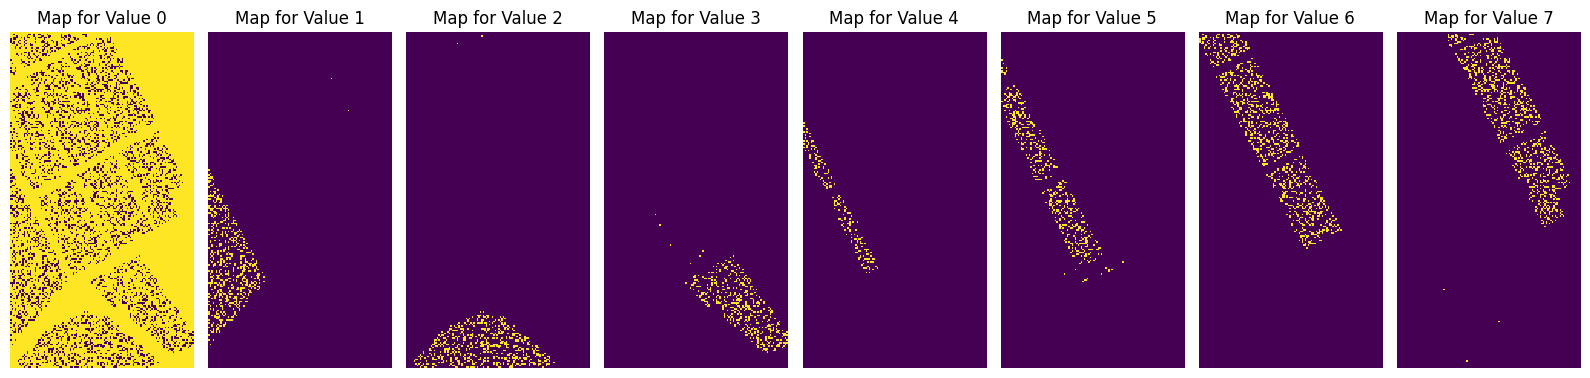

In [41]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(1, 8, figsize=(16, 8))

# Iterate through each value to plot the corresponding map
for value, ax in enumerate(axes.flatten()):
    # Create a mask where pixels with the specific value are set to 1
    mask = np.where(y_pred_su_knn_op_img == value, 1, 0)

    # Plot the map
    ax.imshow(mask, cmap='viridis', interpolation='nearest')
    ax.set_title(f"Map for Value {value}")
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [43]:
# Calculate accuracy
accuracy = accuracy_score(y_opt, y_pred_su_knn_op)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.9933837429111532


The performance of the kNN classifier on the operational set that was trained on the full spectra training set is marginally better than the kNN classifier that was trained on the same dataset after spectral unmixing. Another explanation is that the spectral unmixing gives us access to subpixel information leading to different classification and potentially improved performance.